In [2]:
import os
import pandas as pd
from IPython.display import display

# Liste til at samle dataframes
sampled_dfs = []

# Find nuværende mappe
base_dir = os.getcwd()

# Gennemgå ALLE filer i undermapper (rekursivt)
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "T_ONTIME_REPORTING.csv":  # Matcher filnavne præcist
            csv_path = os.path.join(root, file)
            try:
                # Robust indlæsning (sniffer separator, skipper dårlige linjer)
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="utf-8", on_bad_lines="skip")
                except Exception:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")

                print(f"📂 Indlæst: {csv_path}")

                # Tag en stikprøve på maks 300 rækker pr. fil
                sample_size = min(300, len(df))
                sample = df.sample(sample_size, random_state=42)
                sampled_dfs.append(sample)

                print(f"✅ Tilføjet: {csv_path} ({sample_size} rækker)")

            except Exception as e:
                print(f"⚠️ Fejl ved indlæsning af {csv_path}: {e}")

# Kombinér alle filer til ét samlet dataframe
if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"\n📊 Samlet dataframe med {len(df):,} rækker fra {len(sampled_dfs)} filer.")
    display(df.head())
else:
    print("❌ Ingen data fundet – tjek filnavne eller placering.")



📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/April/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/december/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/february/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/June/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv
✅ Tilføjet: /Users/robinribelrifai/Desktop/Data months/July/T_ONTIME_REPORTING.csv (300 rækker)
📂 Indlæst: /Users/robinribelrifai/Desktop/Data months/August/T_ONTIME_REPORTING.csv
✅ Tilføj

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE
0,2024,4,12,18,3,12/18/2024 12:00:00 AM,1293.0,12892,LAX,California,...,"Seattle, WA",Washington,600,553.0,858.0,846.0,0.0,0800-0859,1.0,954.0
1,2024,4,12,13,5,12/13/2024 12:00:00 AM,3764.0,13930,ORD,Illinois,...,"Indianapolis, IN",Indiana,1338,1336.0,1537.0,1531.0,0.0,1500-1559,1.0,177.0
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,"Houston, TX",Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,"Jacksonville/Camp Lejeune, NC",North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0
4,2024,4,12,13,5,12/13/2024 12:00:00 AM,5374.0,11150,CSG,Georgia,...,"Atlanta, GA",Georgia,1742,1734.0,1845.0,1814.0,0.0,1800-1859,1.0,83.0


Renset: 54 rækker fjernet, tilbage: 3546
DataFrame: 3546 rækker, 12 kolonner.
Train size: 2836, Test size: 710

--- Test Data Metrics (Target = target_delay_min) ---
Ridge → MSE: 1947.68 | RMSE: 44.13 | R²: -0.004
Lasso → MSE: 1942.08 | RMSE: 44.07 | R²: -0.001


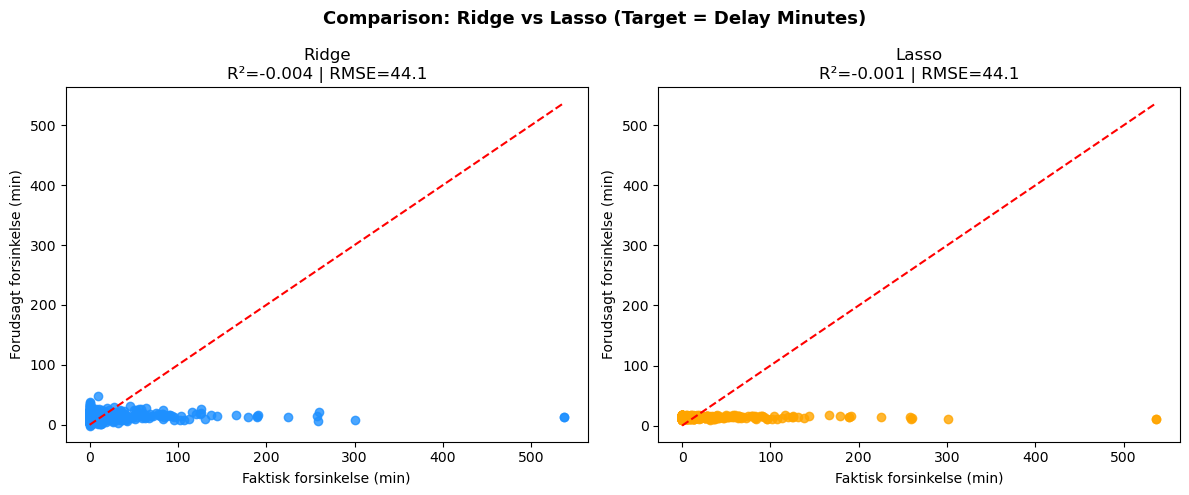

,Model,MSE,RMSE (min),R²,Alpha
0,Ridge,1947.678984,44.132516,-0.004065,30.000000
1,Lasso,1942.081182,44.069050,-0.001179,1.000000



--- Ridge på ALT data (target_delay_min) ---
Ridge (ALT data) → MSE: 1618.43 | RMSE: 40.23 | R²: 0.071


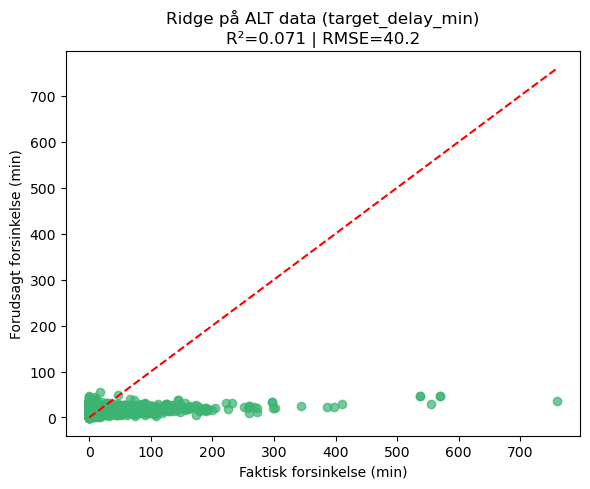

In [3]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import display
import re

# === Vælg nødvendige kolonner fra df ===
kolonner = [
    "MONTH","DAY_OF_WEEK","DAY_OF_MONTH","DISTANCE",
    "ORIGIN","DEST","OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME","DEP_TIME"  # bruges til minutter
]
# Tag DEP_DELAY/CANCELLED/DIVERTED med, hvis de findes
for extra in ["DEP_DELAY", "CANCELLED", "DIVERTED"]:
    if extra in df.columns:
        kolonner.append(extra)

df_small = df[kolonner].copy()

# === Hjælpefunktioner ===
def hhmm_to_minutes(x):
    """Konverterer fx 1325 -> 805 minutter."""
    try:
        x = int(float(x))
        return (x // 100) * 60 + (x % 100)
    except:
        return np.nan

def to_number(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v)
    s = str(v).strip().replace(",", ".")
    if s.count(".") > 1:
        s = s.split(".")[0]
    try:
        return float(s)
    except:
        return pd.to_numeric(s, errors="coerce")

# === Minut-kolonner ===
df_small["DEP_TIME_MIN"] = df_small["DEP_TIME"].apply(hhmm_to_minutes)
df_small["CRS_DEP_TIME_MIN"] = df_small["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# Tving numeriske felter til tal
num_cols = ["MONTH","DAY_OF_WEEK","DAY_OF_MONTH","DISTANCE","CRS_DEP_TIME_MIN","OP_CARRIER_FL_NUM","DEP_TIME_MIN"]
if "DEP_DELAY" in df_small.columns:
    num_cols.append("DEP_DELAY")
for c in num_cols:
    df_small[c] = df_small[c].apply(to_number)

# === Samme target som hende: target_delay_min (clip negative til 0) ===
normmap = {re.sub(r"[^a-z0-9]", "", c.lower()): c for c in df_small.columns}
kandidater = [
    "depdelay","depdelaynew","departuredelay","departuredelaymin",
    "depdelaymin","depdelayminutes","dep_delay_min","dep_delay_minutes","dep_delay"
]
dep_delay_col = None
for k in kandidater:
    if k in normmap:
        dep_delay_col = normmap[k]
        break

if dep_delay_col is not None:
    dep_delay_min = pd.to_numeric(df_small[dep_delay_col], errors="coerce")
else:
    if not {"DEP_TIME_MIN","CRS_DEP_TIME_MIN"}.issubset(df_small.columns):
        raise KeyError("Kan ikke skabe target: mangler både DEP_DELAY og minutter-kolonnerne.")
    dep_delay_min = df_small["DEP_TIME_MIN"] - df_small["CRS_DEP_TIME_MIN"]

df_small["target_delay_min"] = np.clip(dep_delay_min, a_min=0, a_max=None)

if "CANCELLED" in df_small.columns:
    df_small = df_small[df_small["CANCELLED"] != 1]
if "DIVERTED" in df_small.columns:
    df_small = df_small[df_small["DIVERTED"] != 1]

før = len(df_small)
df_small = df_small.dropna(subset=["MONTH","DAY_OF_WEEK","DAY_OF_MONTH","DISTANCE",
                                   "ORIGIN","DEST","OP_CARRIER_FL_NUM",
                                   "CRS_DEP_TIME_MIN","target_delay_min"])
efter = len(df_small)
print(f"Renset: {før-efter} rækker fjernet, tilbage: {efter}")
print(f"DataFrame: {df_small.shape[0]} rækker, {df_small.shape[1]} kolonner.")

# === Definér X (features) og y (target) UDEN lækage ===
kolonner_der_ikke_maa_vaere_i_X = {"DEP_TIME","DEP_TIME_MIN","target_delay_min"}
if dep_delay_col is not None:
    kolonner_der_ikke_maa_vaere_i_X.add(dep_delay_col)

X = df_small.drop(columns=[c for c in kolonner_der_ikke_maa_vaere_i_X if c in df_small.columns])
y = df_small["target_delay_min"].astype(float)

numeric_features = ["MONTH","DAY_OF_WEEK","DAY_OF_MONTH","DISTANCE","CRS_DEP_TIME_MIN","OP_CARRIER_FL_NUM"]
categorical_features = ["ORIGIN","DEST"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# === Split, train, eval ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

pipe_ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", RidgeCV(alphas=[0.1, 1, 3, 10, 30], scoring="neg_mean_squared_error", cv=5))
])
pipe_ridge.fit(X_train, y_train)
y_pred_ridge = pipe_ridge.predict(X_test)

pipe_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("lasso", LassoCV(alphas=[0.1, 1, 3, 10, 30], cv=5, random_state=42, max_iter=10000))
])
pipe_lasso.fit(X_train, y_train)
y_pred_lasso = pipe_lasso.predict(X_test)

# === Metrics ===
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- Test Data Metrics (Target = target_delay_min) ---")
print(f"Ridge → MSE: {mse_ridge:.2f} | RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso → MSE: {mse_lasso:.2f} | RMSE: {rmse_lasso:.2f} | R²: {r2_lasso:.3f}")

# === Plots ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_ridge, alpha=0.8, color="dodgerblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Faktisk forsinkelse (min)")
plt.ylabel("Forudsagt forsinkelse (min)")
plt.title(f"Ridge\nR²={r2_ridge:.3f} | RMSE={rmse_ridge:.1f}")

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_lasso, alpha=0.8, color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Faktisk forsinkelse (min)")
plt.ylabel("Forudsagt forsinkelse (min)")
plt.title(f"Lasso\nR²={r2_lasso:.3f} | RMSE={rmse_lasso:.1f}")
plt.suptitle("Comparison: Ridge vs Lasso (Target = Delay Minutes)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# === Resultattabel ===
summary = pd.DataFrame({
    "Model": ["Ridge", "Lasso"],
    "MSE": [mse_ridge, mse_lasso],
    "RMSE (min)": [rmse_ridge, rmse_lasso],
    "R²": [r2_ridge, r2_lasso],
    "Alpha": [
        pipe_ridge.named_steps["ridge"].alpha_,
        pipe_lasso.named_steps["lasso"].alpha_
    ]
})
display(summary.style.set_caption("📊 Modelresultater (target_delay_min)"))

# === Ekstra: Ridge på ALT data ===
print("\n--- Ridge på ALT data (target_delay_min) ---")
pipe_ridge.fit(X, y)
y_pred_all = pipe_ridge.predict(X)
mse_all = mean_squared_error(y, y_pred_all)
rmse_all = np.sqrt(mse_all)
r2_all = r2_score(y, y_pred_all)
print(f"Ridge (ALT data) → MSE: {mse_all:.2f} | RMSE: {rmse_all:.2f} | R²: {r2_all:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(y, y_pred_all, alpha=0.7, color="mediumseagreen")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Faktisk forsinkelse (min)")
plt.ylabel("Forudsagt forsinkelse (min)")
plt.title(f"Ridge på ALT data (target_delay_min)\nR²={r2_all:.3f} | RMSE={rmse_all:.1f}")
plt.tight_layout()
plt.show()



In [4]:
# Add holiday attribute
df['Holiday?'] = (
    ((df['MONTH'] == 12) & (df['DAY_OF_MONTH'] >= 20)) |  # Dec 20–31
    ((df['MONTH'] == 1) & (df['DAY_OF_MONTH'] <= 5))   |  # Jan 1–5
    (df['MONTH'].isin([7, 8]))                           # July & August
)
# Filtrér så vi kun viser data fra holiday-perioden
df = df[df["Holiday?"] == True]
df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_NM,...,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,CRS_ARR_TIME,ARR_TIME,ARR_DEL15,ARR_TIME_BLK,FLIGHTS,DISTANCE,Holiday?
2,2024,4,12,31,2,12/31/2024 12:00:00 AM,1788.0,14747,SEA,Washington,...,Texas,704,701.0,1327.0,1315.0,0.0,1300-1359,1.0,1874.0,True
3,2024,4,12,22,7,12/22/2024 12:00:00 AM,5487.0,11057,CLT,North Carolina,...,North Carolina,2047,2139.0,2156.0,2230.0,1.0,2100-2159,1.0,191.0,True
5,2024,4,12,25,3,12/25/2024 12:00:00 AM,3176.0,11298,DFW,Texas,...,Michigan,945,936.0,1328.0,1310.0,0.0,1300-1359,1.0,986.0,True
6,2024,4,12,28,6,12/28/2024 12:00:00 AM,4284.0,10423,AUS,Texas,...,Texas,1850,1942.0,1955.0,2047.0,1.0,1900-1959,1.0,189.0,True
10,2024,4,12,25,3,12/25/2024 12:00:00 AM,1539.0,14908,SNA,California,...,North Carolina,840,838.0,1622.0,1555.0,0.0,1600-1659,1.0,2099.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2024,3,8,15,4,8/15/2024 12:00:00 AM,714.0,14747,SEA,Washington,...,California,1244,1236.0,1534.0,1531.0,0.0,1500-1559,1.0,1050.0,True
3296,2024,3,8,14,3,8/14/2024 12:00:00 AM,6208.0,10372,ASE,Colorado,...,Texas,1428,1416.0,1740.0,1717.0,0.0,1700-1759,1.0,701.0,True
3297,2024,3,8,21,3,8/21/2024 12:00:00 AM,5458.0,10980,CHA,Tennessee,...,North Carolina,1058,1046.0,1221.0,1214.0,0.0,1200-1259,1.0,241.0,True
3298,2024,3,8,29,4,8/29/2024 12:00:00 AM,2337.0,14100,PHL,Pennsylvania,...,Michigan,934,921.0,1116.0,1108.0,0.0,1100-1159,1.0,453.0,True


Amount of holiday rows: 466
Cleaned: 8 rows removed, 458 rows remaining

✅ Model trained on HOLIDAY-data (target = delay in minutes)
Ridge → MSE: 1454.74 | RMSE: 38.14 | R²: 0.167
Lasso → MSE: 1637.26 | RMSE: 40.46 | R²: 0.062


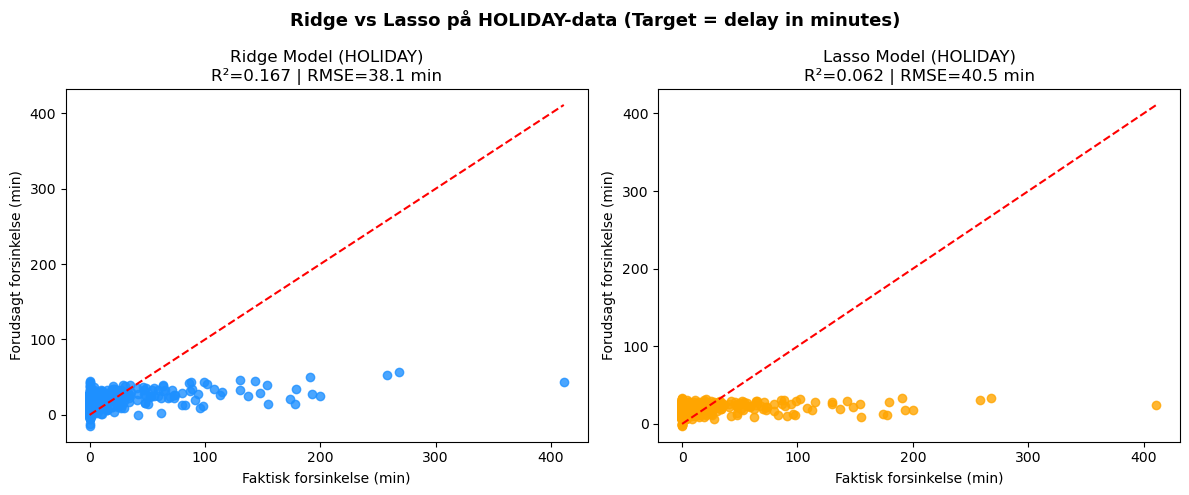

,Model,MSE,RMSE (min),R²,Alpha
0,Ridge,1454.744354,38.141111,0.166782,30.000000
1,Lasso,1637.260757,40.463079,0.062244,3.000000


In [6]:
# --- Import libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from IPython.display import display

# =========================================================
# 1. Define holiday-filtering
# =========================================================
df["Holiday?"] = (
    ((df["MONTH"] == 12) & (df["DAY_OF_MONTH"] >= 20)) |  # Dec 20–31
    ((df["MONTH"] == 1) & (df["DAY_OF_MONTH"] <= 5))  |   # Jan 1–5
    (df["MONTH"].isin([7, 8]))                            # July & August
)

df = df[df["Holiday?"] == True].copy()
print(f"Amount of holiday rows: {len(df)}")

# =========================================================
# 2. Select relevant columns
# =========================================================
kolonner = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "ORIGIN", "DEST",
    "OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME"
]
df_small = df[kolonner].copy()

# =========================================================
# 3. Convert HHMM to minutes since midnight
# =========================================================
def hhmm_to_minutes(x):
    """Konverterer fx 1325 → 13*60 + 25 = 805 minutter."""
    try:
        x = int(float(x))
        hh = x // 100
        mm = x % 100
        if mm >= 60:
            return np.nan
        return hh * 60 + mm
    except:
        return np.nan

df_small["DEP_TIME_MIN"] = df_small["DEP_TIME"].apply(hhmm_to_minutes)
df_small["CRS_DEP_TIME_MIN"] = df_small["CRS_DEP_TIME"].apply(hhmm_to_minutes)

# =========================================================
# 4. Convert numeric columns
# =========================================================
def to_number(v):
    """Sørg for at værdier konverteres korrekt til float."""
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v)
    s = str(v).strip().replace(",", ".")
    if s.count(".") > 1:
        s = s.split(".")[0]
    try:
        return float(s)
    except:
        return pd.to_numeric(s, errors="coerce")

num_cols = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "CRS_DEP_TIME_MIN", "OP_CARRIER_FL_NUM", "DEP_TIME_MIN"
]
for c in num_cols:
    df_small[c] = df_small[c].apply(to_number)

# =========================================================
# 5. Compute target (delay in minutes)
# =========================================================
df_small["target_delay_min"] = np.clip(
    df_small["DEP_TIME_MIN"] - df_small["CRS_DEP_TIME_MIN"],
    a_min=0, a_max=None
)

# =========================================================
# 6. Remove NaNs and print status
# =========================================================
før = len(df_small)
df_small = df_small.dropna(subset=[
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "ORIGIN", "DEST",
    "OP_CARRIER_FL_NUM", "CRS_DEP_TIME_MIN", "DEP_TIME_MIN", "target_delay_min"
])
efter = len(df_small)
print(f"Cleaned: {før-efter} rows removed, {efter} rows remaining")

# =========================================================
# 7. Define X (features) and y (target)
# =========================================================
X = df_small.drop(columns=["DEP_TIME", "CRS_DEP_TIME", "CRS_DEP_TIME_MIN", "target_delay_min"])
y = df_small["target_delay_min"].astype(float)

numeric_features = [
    "MONTH", "DAY_OF_WEEK", "DAY_OF_MONTH",
    "DISTANCE", "OP_CARRIER_FL_NUM", "DEP_TIME_MIN"
]
categorical_features = ["ORIGIN", "DEST"]

# =========================================================
# 8. Preprocessing (scaling + one-hot)
# =========================================================
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# =========================================================
# 9. Train Ridge and Lasso models
# =========================================================
pipe_ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", RidgeCV(alphas=[0.1, 1, 3, 10, 30],
                      scoring="neg_mean_squared_error", cv=5))
])
pipe_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("lasso", LassoCV(alphas=[0.1, 1, 3, 10, 30],
                      cv=5, random_state=42, max_iter=10000))
])

pipe_ridge.fit(X, y)
pipe_lasso.fit(X, y)
y_pred_ridge = pipe_ridge.predict(X)
y_pred_lasso = pipe_lasso.predict(X)

# =========================================================
# 10. Evaluate model performance
# =========================================================
mse_ridge = mean_squared_error(y, y_pred_ridge)
mse_lasso = mean_squared_error(y, y_pred_lasso)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)
r2_ridge = r2_score(y, y_pred_ridge)
r2_lasso = r2_score(y, y_pred_lasso)

print("\n✅ Model trained on HOLIDAY-data (target = delay in minutes)")
print(f"Ridge → MSE: {mse_ridge:.2f} | RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso → MSE: {mse_lasso:.2f} | RMSE: {rmse_lasso:.2f} | R²: {r2_lasso:.3f}")

# =========================================================
# 11. Visualization
# =========================================================
plt.figure(figsize=(12, 5))

# Ridge plot
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_ridge, alpha=0.8, color="dodgerblue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Faktisk forsinkelse (min)")
plt.ylabel("Forudsagt forsinkelse (min)")
plt.title(f"Ridge Model (HOLIDAY)\nR²={r2_ridge:.3f} | RMSE={rmse_ridge:.1f} min")

# Lasso plot
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_lasso, alpha=0.8, color="orange")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Faktisk forsinkelse (min)")
plt.ylabel("Forudsagt forsinkelse (min)")
plt.title(f"Lasso Model (HOLIDAY)\nR²={r2_lasso:.3f} | RMSE={rmse_lasso:.1f} min")

plt.suptitle("Ridge vs Lasso på HOLIDAY-data (Target = delay in minutes)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# =========================================================
# 12. Summary table
# =========================================================
summary = pd.DataFrame({
    "Model": ["Ridge", "Lasso"],
    "MSE": [mse_ridge, mse_lasso],
    "RMSE (min)": [rmse_ridge, rmse_lasso],
    "R²": [r2_ridge, r2_lasso],
    "Alpha": [
        pipe_ridge.named_steps["ridge"].alpha_,
        pipe_lasso.named_steps["lasso"].alpha_
    ]
})
display(summary.style.set_caption("📊 Modelresultater (HOLIDAY – target_delay_min)"))
